In [1]:
from backtesting.test import SMA

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.lib import SignalStrategy, TrailingStrategy

def EMA(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Exponential Moving Average
    return: np.ndarray
    """
    return ta.ema(pd.Series(df), length=n, fillna=fillna)

def Zscore(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Zscore
    return: np.ndarray
    """
    return ta.zscore(pd.Series(df), length=n, fillna=fillna)

class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)

class EmaCross_with_Zscore(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    z_n = 10
    trailing_stop = 2
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        ema1 = self.I(EMA, self.data.Close, self.n1)
        ema2 = self.I(EMA, self.data.Close, self.n2)
        zscore = self.I(Zscore, self.data.Close, self.z_n)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = ((pd.Series(ema1) > ema2) & (pd.Series(zscore) > 0)).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(self.trailing_stop)

In [3]:
data = pd.read_csv('./data/BTCUSDT_1h.csv', index_col='time', parse_dates=True)

In [4]:
#rename columns
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [5]:
data.head()

,Open,High,Low,Close,Volume
time,,,,,
2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049
2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038
2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365
2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307
2020-01-01 04:00:00,7221.80,7225.41,7211.22,7213.86,1176.666


In [6]:
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [7]:
from backtesting import Backtest

bt = Backtest(data, EmaCross_with_Zscore, commission=.002,cash=100000)

bt.run()


Start                     2020-01-01 00:00:00
End                       2023-01-09 03:00:00
Duration                   1104 days 03:00:00
Exposure Time [%]                    45.69434
Equity Final [$]                  32051.44404
Equity Peak [$]                  110738.37874
Return [%]                         -67.948556
Buy & Hold Return [%]              139.670643
Return (Ann.) [%]                  -31.329029
Volatility (Ann.) [%]                26.39802
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -71.267645
Avg. Drawdown [%]                  -10.886869
Max. Drawdown Duration     1076 days 04:00:00
Avg. Drawdown Duration      137 days 17:00:00
# Trades                                  695
Win Rate [%]                         33.81295
Best Trade [%]                      21.806842
Worst Trade [%]                    -18.987593
Avg. Trade [%]                    

In [8]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    z_n=range(5, 30, 5),
                    trailing_stop=range(1, 10, 1),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

C:\Users\hiban\AppData\Roaming\Python\Python310\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 2250 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: total: 9min 38s
Wall time: 15min 20s


Start                     2020-01-01 00:00:00
End                       2023-01-09 03:00:00
Duration                   1104 days 03:00:00
Exposure Time [%]                   65.886792
Equity Final [$]                 516033.14622
Equity Peak [$]                   910687.3237
Return [%]                         416.033146
Buy & Hold Return [%]              139.670643
Return (Ann.) [%]                   71.952836
Volatility (Ann.) [%]               92.408509
Sharpe Ratio                         0.778639
Sortino Ratio                        2.432363
Calmar Ratio                         1.579648
Max. Drawdown [%]                  -45.549927
Avg. Drawdown [%]                    -3.13296
Max. Drawdown Duration      445 days 12:00:00
Avg. Drawdown Duration        6 days 12:00:00
# Trades                                  249
Win Rate [%]                        46.586345
Best Trade [%]                      34.221736
Worst Trade [%]                    -12.566866
Avg. Trade [%]                    

In [9]:
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
time,,,
2020-01-01 00:00:00,100000.00000,0.000000,NaT
2020-01-01 01:00:00,100000.00000,0.000000,NaT
2020-01-01 02:00:00,100000.00000,0.000000,NaT
2020-01-01 03:00:00,100000.00000,0.000000,NaT
2020-01-01 04:00:00,100000.00000,0.000000,NaT
...,...,...,...
2023-01-08 23:00:00,514345.34622,0.435212,NaT
2023-01-09 00:00:00,515917.14622,0.433486,NaT
2023-01-09 01:00:00,515572.04622,0.433865,NaT


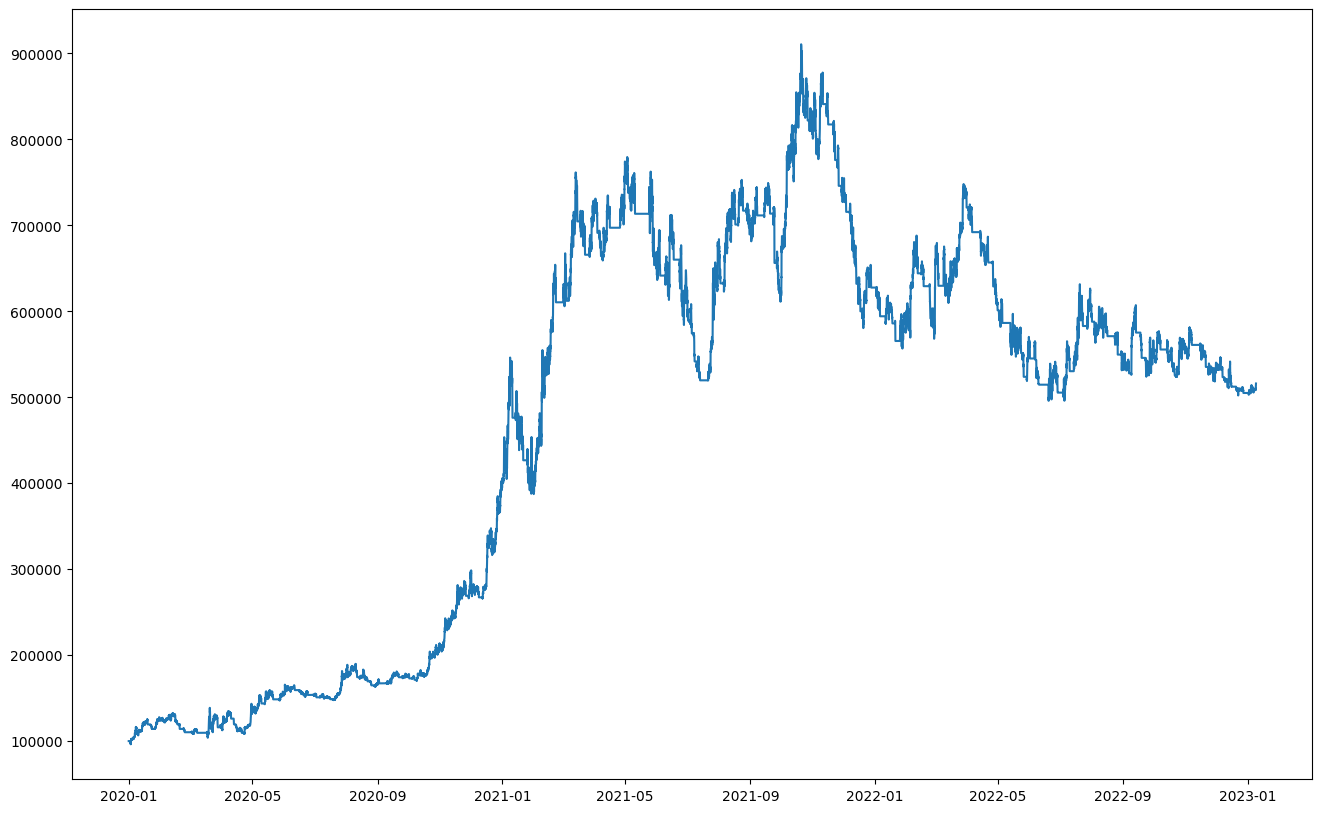

In [10]:
import matplotlib.pyplot as plt

#stats['_equity_curve']
plt.figure(figsize=(16, 10))
plt.plot(stats['_equity_curve']['Equity'])
plt.show()